# Natural Language Processing (CS221.O22) - Final Project -

* **Môn học:** Xử lý ngôn ngữ tự nhiên - CS221.O22

* **Chủ đề:** Multi-Stage Document Ranking for Vietnamese News Retrieval



# Introduction
Trong thời đại cách mạng công nghiệp 4.0, Internet trở thành nguồn tài nguyên thông tin khổng lồ. Việc sử dụng các công cụ tìm kiếm như Google, Bing, ... để tra cứu thông tin trở nên phổ biến và quen thuộc với con người. Thế nhưng, **làm thế nào mà các công cụ tìm kiếm này có thể hiểu được câu truy vấn và trả về các thông tin liên quan?** Bắt nguồn từ câu hỏi này, nhóm quyết định tìm hiểu để xây dựng và tái hiện lại một hệ thống tương tự.

Cho một truy vấn **$q$** và một ngữ liệu ***$D$*** là tập hợp nhiều bài báo khác nhau. Bài toán đặt ra là xây dựng một hệ thống nhận vào truy vấn q và trả về các bài báo từ D, trong đó:

1. Chứa các ngữ cảnh quan trọng liên quan đến $q$.

2. Các bài báo được xếp hạng từ trên xuống dưới theo **mức độ liên quan** đến truy vấn. Các bài báo có độ liên quan cao hơn thì có xếp hạng (rank) cao hơn


# 1. Import packages and libraries

In [1]:
#import needed libraries

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

import requests
import re
from bs4 import BeautifulSoup

!pip install py_vncorenlp
import py_vncorenlp

import torch

!pip install transformers
from transformers import AutoModel, AutoTokenizer

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

!pip install rank_bm25
from rank_bm25 import BM25Okapi

import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.8 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4306 sha256=6a4e65ffc580c541e62b692ae877c0f1cbdb750a2adb5dc531ad20a513b6b2e7
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir /content/py_vncorenlp

# Trước khi đưa vào PhoBERT cần thực hiện tokenization, việc này được thực hiện bằng cách dùng py_vncorenlp
py_vncorenlp.download_model(save_dir = "/content/py_vncorenlp")
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/py_vncorenlp')

In [5]:
# Download các model cần thiết
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
vsbert = SentenceTransformer('keepitreal/vietnamese-sbert')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 2. Data processing + Query input

## 2.1. Data crawling

In [6]:
data = pd.read_csv('/content/drive/MyDrive/CS221_NLP/Articles.csv', encoding = 'utf-8-sig')

In [7]:
data

title  \
0      Cấm vợ, chồng, anh chị em ruột tham gia đấu gi...   
1      Giá vàng thế giới giảm sâu, giá USD tự do cao ...   
2      Vàng nhẫn giảm sâu, giá USD tự do lập đỉnh kỷ ...   
3      Chính phủ kiến nghị cho phép sử dụng 18.220 tỷ...   
4      Giá vàng đứng im 17 phiên liên tiếp, giá thế g...   
...                                                  ...   
48352  Phát hiện giúp con người có thể giao tiếp với ...   
48353  Bão Mặt trời mạnh nhất 20 năm vừa tấn công Trá...   
48354   Dòng sông bẩn nhất thế giới đã được cứu thế nào?   
48355  Hành trình ‘săn’ nhật thực 13 lần trong đời củ...   
48356  Trung Quốc lại đột phá trong phát minh, tạo ra...   

                                                abstract       source  \
0      (Dân trí) - Luật sửa đổi, bổ sung một số điều ...  Báo Dân Trí   
1      (Dân trí) - Giá vàng trong nước đứng im. Vàng ...  Báo Dân Trí   
2      (Dân trí) - Giá vàng miếng SJC không thay đổi ...  Báo Dân Trí   
3      (Dân trí) - Ủy ban Tài chính Ngân sách kiến ng...  Báo Dân Trí   
4      (Dân trí) - Giá vàng thế giới giảm sâu do chịu...  Báo Dân Trí   
...                                                  ...          ...   
48352  Các nhà nghiên cứu cho rằng ngôn ngữ của cá nh...      Báo VTC   
48353  Bão Mặt trời mạnh nhất hơn hai thập kỷ đã tấn ...      Báo VTC   
48354  Các quốc gia tìm mọi cách cứu lấy những dòng s...      Báo VTC   
48355  Ở tuổi 105, ông Laverne Biser chứng kiến 13 lầ...      Báo VTC   
48356  Các nhà khoa học Trung Quốc đã phát triển một ...      Báo VTC   

                                                    link       topic  
0      https://dantri.com.vn//kinh-doanh/cam-vo-chong...  Kinh doanh  
1      https://dantri.com.vn//kinh-doanh/gia-vang-the...  Kinh doanh  
2      https://dantri.com.vn//kinh-doanh/vang-nhan-gi...  Kinh doanh  
3      https://dantri.com.vn//kinh-doanh/chinh-phu-ki...  Kinh doanh  
4      https://dantri.com.vn//kinh-doanh/gia-vang-dun...  Kinh doanh  
...                                                  ...         ...  
48352  https://vtc.vn/phat-hien-giup-con-nguoi-co-the...    Khám phá  
48353  https://vtc.vn/bao-mat-troi-manh-nhat-20-nam-v...    Khám phá  
48354  https://vtc.vn/dong-song-ban-nhat-the-gioi-da-...    Khám phá  
48355  https://vtc.vn/hanh-trinh-san-nhat-thuc-13-lan...    Khám phá  
48356  https://vtc.vn/trung-quoc-lai-dot-pha-trong-ph...    Khám phá  

[48357 rows x 5 columns]

In [8]:
data.head()

title  \
0  Cấm vợ, chồng, anh chị em ruột tham gia đấu gi...   
1  Giá vàng thế giới giảm sâu, giá USD tự do cao ...   
2  Vàng nhẫn giảm sâu, giá USD tự do lập đỉnh kỷ ...   
3  Chính phủ kiến nghị cho phép sử dụng 18.220 tỷ...   
4  Giá vàng đứng im 17 phiên liên tiếp, giá thế g...   

                                            abstract       source  \
0  (Dân trí) - Luật sửa đổi, bổ sung một số điều ...  Báo Dân Trí   
1  (Dân trí) - Giá vàng trong nước đứng im. Vàng ...  Báo Dân Trí   
2  (Dân trí) - Giá vàng miếng SJC không thay đổi ...  Báo Dân Trí   
3  (Dân trí) - Ủy ban Tài chính Ngân sách kiến ng...  Báo Dân Trí   
4  (Dân trí) - Giá vàng thế giới giảm sâu do chịu...  Báo Dân Trí   

                                                link       topic  
0  https://dantri.com.vn//kinh-doanh/cam-vo-chong...  Kinh doanh  
1  https://dantri.com.vn//kinh-doanh/gia-vang-the...  Kinh doanh  
2  https://dantri.com.vn//kinh-doanh/vang-nhan-gi...  Kinh doanh  
3  https://dantri.com.vn//kinh-doanh/chinh-phu-ki...  Kinh doanh  
4  https://dantri.com.vn//kinh-doanh/gia-vang-dun...  Kinh doanh

In [9]:
titles = data['title']
abstracts = data['abstract']
titles

0        Cấm vợ, chồng, anh chị em ruột tham gia đấu gi...
1        Giá vàng thế giới giảm sâu, giá USD tự do cao ...
2        Vàng nhẫn giảm sâu, giá USD tự do lập đỉnh kỷ ...
3        Chính phủ kiến nghị cho phép sử dụng 18.220 tỷ...
4        Giá vàng đứng im 17 phiên liên tiếp, giá thế g...
                               ...                        
48352    Phát hiện giúp con người có thể giao tiếp với ...
48353    Bão Mặt trời mạnh nhất 20 năm vừa tấn công Trá...
48354     Dòng sông bẩn nhất thế giới đã được cứu thế nào?
48355    Hành trình ‘săn’ nhật thực 13 lần trong đời củ...
48356    Trung Quốc lại đột phá trong phát minh, tạo ra...
Name: title, Length: 48357, dtype: object

## 2.2. Data Analysis

Có thể thấy tổng số lượng các bài báo là 40279. Số lượng của từng bài báo được lấy như sau

In [10]:
data['source'].value_counts(sort = False)

source
Báo Dân Trí           5830
Báo Đảng Cộng Sản     8810
Báo Lao Động         13055
Báo VnExpress        10765
Báo VTC               9897
Name: count, dtype: int64

Số lượng các bài báo tương ứng với mỗi loại chủ đề

In [11]:
data['topic'].value_counts(sort = False)

topic
Kinh doanh                 2737
Xã hội                     3495
Thế giới                   3372
Giải trí                   1867
Bất động sản                956
Thể thao                   3508
Việc làm                    300
Sức khỏe                   1945
Xe ++                       353
Sức mạnh số                 283
Giáo dục                   3401
An sinh                     259
Pháp luật                  3448
Du lịch                     925
Đời sống                    919
Tình yêu                    275
Khoa học - Công nghệ        277
Thời sự                    4294
Lãnh đạo Đảng, Nhà nước    1200
Xây dựng Đảng              1199
Văn hóa                    1193
Kinh tế                    2099
Nơi hay dựng                421
Cùng bàn luận              1197
Bạn đọc                    1550
Euro 2024                   594
Góc nhìn                    606
Khoa học                    605
Podcasts                    600
Số hóa                      593
Xe                         1498
Ý 

Có thể thấy một số chủ đề khác nhau nhưng lại có ý nghĩa tương đồng. Ta tiến hành gộp các chủ đề này lại:
* Xe, Xe ++ = Xe
* Khoa học - Công nghệ, Khoa học = Khoa học
* Thể thao, Euro 2024 = Thể thao
* Sức mạnh số, Số hóa = Số hóa

Ngoài ra chuyên mục 'Nói hay Đừng' của báo Đảng Cộng sản bị sai cần sửa lại

In [12]:
data['topic'].replace( {'Xe ++': 'Xe',
                        'Khoa học - Công nghệ': 'Khoa học',
                        'Euro 2024': 'Thể thao',
                        'Sức mạnh số': 'Số hóa',
                        'Nơi hay dựng': 'Nói hay Đừng'},
                       inplace = True )
data['topic'].value_counts(sort = False)

topic
Kinh doanh                 2737
Xã hội                     3495
Thế giới                   3372
Giải trí                   1867
Bất động sản                956
Thể thao                   4102
Việc làm                    300
Sức khỏe                   1945
Xe                         1851
Số hóa                      876
Giáo dục                   3401
An sinh                     259
Pháp luật                  3448
Du lịch                     925
Đời sống                    919
Tình yêu                    275
Khoa học                    882
Thời sự                    4294
Lãnh đạo Đảng, Nhà nước    1200
Xây dựng Đảng              1199
Văn hóa                    1193
Kinh tế                    2099
Nói hay Đừng                421
Cùng bàn luận              1197
Bạn đọc                    1550
Góc nhìn                    606
Podcasts                    600
Ý kiến                      595
Khoa học công nghệ          870
Phóng sự                    888
Khám phá                     35
Na

## 2.3. Preprocessing

Tiền xử lý dữ liệu cho text, nhóm thực hiện 4 bước tiền xử lý dữ liệu bao gồm:

+ Lowercasing: Sửa chữ hoa thành chữ thường. Ví dụ: Tp.HCM -> tp.hcm

+ Word-segmented: Nhóm các tiếng thuộc một từ ghép lại. Ví dụ: nghiên cứu viên -> nghiên_cứu_viên

+ Loại bỏ stopwords: Loại bỏ các từ không quan trọng trong nội dung của bài báo. Nói cách khác, nếu những từ không quan trọng này có hay không có trong một câu thì cũng không làm thay đổi nghĩa của câu đó.

+ Loại bỏ một số ký tự đặc biệt, ví dụ như &, *, ...

### 2.3.1. Lowercasing

In [13]:
def lower_text(text):
    ptext = text.lower()
    return ptext

In [14]:
pfi =  [lower_text(titles[i]) + " " + lower_text( str(abstracts[i]) ) for i in range( len(titles) ) ]
pfi[0:3]

['cấm vợ, chồng, anh chị em ruột tham gia đấu giá cùng một tài sản (dân trí) - luật sửa đổi, bổ sung một số điều của luật đấu giá tài sản vừa được quốc hội thông qua cấm vợ, chồng, anh ruột, chị ruột, em ruột tham gia phiên đấu giá đối với cùng một tài sản.',
 'giá vàng thế giới giảm sâu, giá usd tự do cao nhất từ đầu năm (dân trí) - giá vàng trong nước đứng im. vàng thế giới giảm 11 usd so với hôm qua, xuống dưới 2.319 usd/ounce. giá vàng giảm trong bối cảnh giá usd tự do tiến sát 26.000 đồng/usd.',
 'vàng nhẫn giảm sâu, giá usd tự do lập đỉnh kỷ lục 26.030 đồng (dân trí) - giá vàng miếng sjc không thay đổi sau 17 phiên. vàng nhẫn giảm 150.000 đồng mỗi lượng so với phiên liền trước đó. giá usd tự do chính thức vượt 26.030 đồng/usd, mức giá cao nhất mọi thời đại.']

### 2.3.2. Word-segmented

In [15]:
def segment_text(text):
  text = rdrsegmenter.word_segment(text)
  return str(text)

In [16]:
pfi = [segment_text(word) for word in pfi]

In [17]:
pfi[0:3]

["['cấm vợ , chồng , anh_chị_em ruột tham_gia đấu_giá cùng một tài_sản ( dân_trí ) - luật sửa_đổi , bổ_sung một_số điều của luật đấu_giá tài_sản vừa được quốc_hội thông_qua cấm vợ , chồng , anh ruột , chị ruột , em ruột tham_gia phiên đấu_giá đối_với cùng một tài_sản .']",
 "['giá vàng thế_giới giảm sâu , giá usd tự_do cao nhất từ đầu năm ( dân_trí ) - giá vàng trong nước đứng im . vàng thế_giới giảm 11 usd so với hôm_qua , xuống dưới 2.319 usd / ounce . giá vàng giảm trong bối_cảnh giá usd tự_do tiến sát 26.000 đồng / usd .']",
 "['vàng nhẫn giảm sâu , giá usd tự_do lập đỉnh kỷ_lục 26.030 đồng ( dân_trí ) - giá vàng miếng sjc không thay_đổi sau 17 phiên . vàng nhẫn giảm 150.000 đồng mỗi lượng so với phiên liền trước đó . giá usd tự_do chính_thức vượt 26.030 đồng / usd , mức giá cao nhất mọi thời_đại .']"]

### 2.3.3. Stopwords Removal

Danh sách các từ dừng được nhóm sử dụng để loại bỏ nằm trong thư viện từ dừng tiếng Việt của tác giả Van-Duyet Le. Link nguồn đã được đính kèm ở dưới.

In [18]:
%cd '/content'

/content


In [19]:
#link : "https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords-dash.txt"
!git clone https://github.com/stopwords/vietnamese-stopwords.git

Cloning into 'vietnamese-stopwords'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 95 (delta 3), reused 0 (delta 0), pack-reused 81
Receiving objects: 100% (95/95), 40.25 KiB | 10.06 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [20]:
stopwords= open('/content/vietnamese-stopwords/vietnamese-stopwords-dash.txt', 'r', encoding='utf-8').read().split("\n")

In [21]:
stopwords[:3]

['a_lô', 'a_ha', 'ai']

In [22]:
def remove_stopwords(stopwords, title):
  tokenized_title = title.split(' ')
  fi_title_words = []

  for word in tokenized_title:
    if word not in stopwords:
      fi_title_words.append(word)

  fi_title = ' '.join(fi_title_words)

  return fi_title

In [23]:
pfi = [remove_stopwords(stopwords, word) for word in pfi]

In [24]:
pfi[:3]

["['cấm vợ , chồng , anh_chị_em ruột tham_gia đấu_giá tài_sản ( dân_trí ) - luật sửa_đổi , bổ_sung luật đấu_giá tài_sản quốc_hội thông_qua cấm vợ , chồng , ruột , ruột , ruột tham_gia phiên đấu_giá tài_sản .']",
 "['giá vàng thế_giới sâu , giá usd tự_do đầu ( dân_trí ) - giá vàng đứng im . vàng thế_giới 11 usd hôm_qua , 2.319 usd / ounce . giá vàng bối_cảnh giá usd tự_do tiến sát 26.000 đồng / usd .']",
 "['vàng nhẫn sâu , giá usd tự_do lập đỉnh kỷ_lục 26.030 đồng ( dân_trí ) - giá vàng miếng sjc 17 phiên . vàng nhẫn 150.000 đồng phiên liền . giá usd tự_do chính_thức 26.030 đồng / usd , giá thời_đại .']"]

### 2.3.4. Special Characters Removal

In [25]:
#Danh sách các ký tự đặc biệt
special_characters = [
    '!', '"', '#', '$', '%', '&', "'", '(', ')', '*',
    '+', ',', '-', '.', '/', ':', ';', '<', '=', '>',
    '?', '@', '[', '\\', ']', '^', '', '{', '|',
    '}', '~'
]

In [26]:
#Lọc ký tự đặc biệt
def remove_special_characters(title):
    cleaned_title = ''.join(char for char in title if char not in special_characters)
    return cleaned_title

In [27]:
prpfi = [remove_special_characters(title) for title in pfi]

In [28]:
prpfi[:3]

['cấm vợ  chồng  anh_chị_em ruột tham_gia đấu_giá tài_sản  dân_trí   luật sửa_đổi  bổ_sung luật đấu_giá tài_sản quốc_hội thông_qua cấm vợ  chồng  ruột  ruột  ruột tham_gia phiên đấu_giá tài_sản ',
 'giá vàng thế_giới sâu  giá usd tự_do đầu  dân_trí   giá vàng đứng im  vàng thế_giới 11 usd hôm_qua  2319 usd  ounce  giá vàng bối_cảnh giá usd tự_do tiến sát 26000 đồng  usd ',
 'vàng nhẫn sâu  giá usd tự_do lập đỉnh kỷ_lục 26030 đồng  dân_trí   giá vàng miếng sjc 17 phiên  vàng nhẫn 150000 đồng phiên liền  giá usd tự_do chính_thức 26030 đồng  usd  giá thời_đại ']

In [29]:
import random as rd

x = rd.randint(0, len(prpfi)-1)
print(x)

print( prpfi[x] )

39538
nền kinh_tế bạc  thị_trường tỷ đô bỏ_ngỏ việt_nam ts đoàn văn bình – phó chủ_tịch hiệp_hội bđs việt_nam  thành_viên hội_đồng tư_vấn du_lịch  tab   kinh_nghiệm phát_triển kinh_tế bạc việt_nam 


Biến prpfi (PReProcessing For Input) là tập hợp nội dung các trang báo điện tử đã được tiền xử lý. Ta thực hiện nhập truy vấn và tiền xử lý cho truy vấn.

# 3. Multi-stage Document Ranking

Phương pháp **Multi-stage Document Ranking**: Thay vì sử dụng một mô hình đơn lẻ để xếp hạng tất cả các tài liệu, multi-stage document ranking áp dụng một chuỗi các mô hình khác nhau, mỗi mô hình thực hiện một chức năng cụ thể. Hướng thực hiện của nhóm sẽ là sử dụng một *phương pháp term-based* như TF-IDF hay BM25 để lọc các bài báo có nội dung không liên quan, các kết quả được lọc ra từ các phương pháp term-based sẽ được đưa vào một mô hình ngôn ngữ được đào tạo trước (pre-trained language model) để xét về mặt ngữ nghĩa văn bản.

Hình dưới là Pineline xử lý của Multi-stage Document Ranking

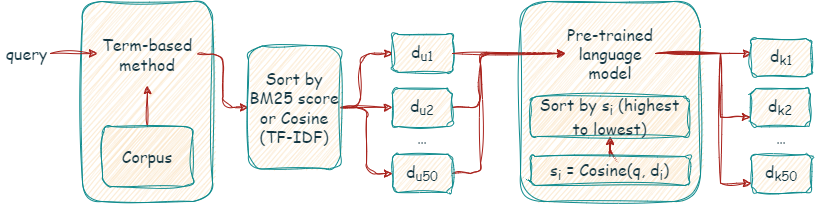

## 3.1. Term-based methods

### 3.1.1. TF-IDF

* Ở đây, $\textbf{TF-IDF}$ được sử dụng với mục đích chuyển đổi các query cùng với corpus (nội dung bài báo bao gồm title và abstrac) về dạng $\textit{feature vector}$. 
* Tiếp đó, các bài báo này sẽ được xếp hạng dựa trên độ đo $\textbf{Cosine Similarity}$.

In [8]:
def TF_IDF_rank(corpus, query):
  vectorizer = TfidfVectorizer()
  corpus_tfidf = vectorizer.fit_transform(corpus + [query])
  cosine_similarities = cosine_similarity(corpus_tfidf[-1], corpus_tfidf[:-1])
  top_indices = cosine_similarities.argsort()[0][::-1]
  # tf_idf_score = []

  for i in range( len(top_indices) ):
    index = top_indices[i]
    top_corpus = [ test_df_contents[ top_indices[i] ] for i in range(50) ]
    prev_index = [ top_indices[i] for i in range(50) ]

  return top_corpus, top_indices

### 3.1.2. BM25

* $\textbf{BM25}$ là một hàm xếp hạng giúp xếp hạng một tập các tài liệu dựa vào việc tính xác xuất xuất hiện của các từ khóa trong câu truy vấn. 
* Khác với TF-IDF, BM25 không tính toán feature vector. Thay vào đó, thuật toán trực tiếp xếp hạng các bài báo dựa trên $\textbf{BM25 score}$

In [30]:
def BM25(corpus, query):
  bm25_test = BM25Okapi([doc.split(' ') for doc in corpus])

  doc_scores = bm25_test.get_scores(query.split(' '))

  BM25_list50_content = bm25_test.get_top_n(query, corpus, n=50)

  content_sorted_indices = sorted( range( len(doc_scores) ), key=lambda i: doc_scores[i], reverse=True )

  return content_sorted_indices, BM25_list50_content

## 3.2. Pre-trained Language Models


Sau khi xếp hạng, ta chọn ra 50 bài báo có xếp hạng cao nhất và những bài báo này sẽ được tiếp tục đưa qua các $\textbf{pre-trained language model}$ để thực hiện $\textit{reranking}$ - sắp xếp lại theo mức độ liên quan với câu truy vấn

### 3.2.1. PhoBERT

Đối với PhoBERT, vector ẩn của token $\textbf{CLS}$ ở đầu ra của lớp transformer cuối cùng được đưa qua một lớp dense (fully connected layer) để giảm chiều, tạo ra vector $\textbf{pooler output}$ và ta sẽ sử dụng vector này sẽ được sử dụng như một feature vector

In [32]:
def PhoBERT_rank(corpus, position, query):
  data_ws = list()
  for col in corpus:
    data_ws.append(str(col) )

  prev_index = position

  input_ids = torch.tensor( [tokenizer.encode(data_ws[0]) ] )
  with torch.no_grad():
    databert = phobert(input_ids).pooler_output.numpy()

  for i in range(1, len(data_ws) ):
    val_ids = torch.tensor( [tokenizer.encode(data_ws[i]) ] )
    with torch.no_grad():
      databert = np.vstack( [databert, phobert(val_ids).pooler_output.numpy().flatten() ] )

  phoquery = query
  cv_query = torch.tensor( [tokenizer.encode( str(phoquery) ) ] )
  with torch.no_grad():
    cv_query = phobert(cv_query).pooler_output.numpy().flatten()
  cossimilarity = []
  for i in range(databert.shape[0] ):
    cossimilarity.append( databert[i,:].dot(cv_query) / (np.linalg.norm(databert[i,:]) * np.linalg.norm(cv_query) ) )

  sorted_ids_data = np.argsort( np.array(cossimilarity) )
  sorted_ids = sorted_ids_data[::-1]
  k = 50
  k_idx = sorted_ids[0: k]
  final_k_idx = [prev_index[i] for i in k_idx]

  return k_idx, final_k_idx

### 3.2.2. Vietnamese-SBERT

Tương tự như PhoBERT, trong Vietnamese-SBERT, ta sẽ sử dụng vector tương ứng với token [CLS] ở đầu ra của lớp transformer cuối cùng làm feature vector.

In [33]:
def Vietnamese_SBERT_rank(corpus, position, query):
  encoded_corpus = vsbert.encode(corpus)
  encoded_query = vsbert.encode(query)

  prev_index = position

  cossimilarity = []
  for i in range(encoded_corpus.shape[0] ):
    cossimilarity.append( encoded_corpus[i,:].dot(encoded_query) / (np.linalg.norm(encoded_corpus[i,:] ) * np.linalg.norm(encoded_query) ) )

  sorted_ids_data = np.argsort(np.array(cossimilarity))
  sorted_ids = sorted_ids_data[::-1]
  k = len(corpus)
  k_idx = sorted_ids[0: k]
  final_k_idx = [prev_index[i] for i in k_idx]

  return k_idx, final_k_idx

## 3.3: Example: BM25 + PhoBERT

Áp dụng Multi-stage Document Ranking với BM25 và PhoBERT (không dùng hàm)



In [34]:
#Nhập query
query = 'Heineken tạm dừng hoạt động'

In [35]:
final_query = remove_special_characters( remove_stopwords(stopwords, segment_text( lower_text(query) ) ) )
final_query

'heineken tạm dừng hoạt_động'

### 3.3.1. BM25

In [36]:
tokenized_corpus = [doc.split(" ") for doc in prpfi]

In [37]:
bm25 = BM25Okapi(tokenized_corpus)
bm25

In [38]:
bmquery = final_query.split(" ")
print(bmquery)
doc_scores = bm25.get_scores(bmquery)

['heineken', 'tạm', 'dừng', 'hoạt_động']


In [39]:
BM25_list50_content = bm25.get_top_n(bmquery, prpfi, n=50)

content_sorted_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)

BM25_list50_titles = bm25.get_top_n(bmquery, titles, n=50)
BM25_list50_titles

['Heineken tạm dừng hoạt động nhà máy bia tại Quảng Nam',
 'Những trung tâm đăng kiểm ở Hà Nội có nguy cơ tạm dừng hoạt động',
 "Quân đội Israel tuyên bố 'tạm dừng chiến thuật' ở Gaza để tiếp tế viện trợ",
 'Tạm dừng hoạt động tại không gian phố đi bộ hồ Hoàn Kiếm trong dịp Tết Giáp Thìn',
 'Tạm dừng hoạt động quán gội đầu lấy 500 nghìn đồng/tiếng ở Huế',
 'Vì sao “Phố đêm du thuyền Hạ Long” được Bộ trưởng đánh giá thành công bị tạm dừng hoạt động?',
 'Hồ Quỳnh Hương: 10 năm dừng hát để ‘chữa lành’ trái tim cạn kiệt cảm xúc',
 'Chủ đầu tư điện mặt trời ở Gia Lai bị dừng mua điện, bị dừng hoạt động',
 'Trước khi tạm rời showbiz, Ninh Dương Lan Ngọc có gì?',
 'Tràn lan dạy thêm, liên kết: Các địa phương tạm dừng để kiểm tra, rà soát',
 'Đề xuất doanh nghiệp khó khăn được dừng đóng kinh phí công đoàn',
 'Đề xuất doanh nghiệp khó khăn được dừng đóng kinh phí công đoàn',
 'Đề xuất doanh nghiệp khó khăn được dừng đóng kinh phí công đoàn',
 'Đề xuất doanh nghiệp khó khăn được dừng đóng kinh p

###3.3.2. PhoBERT

In [40]:
data_ws = list()

for col in BM25_list50_content:
  data_ws.append(str(col) )

data_ws[0]

'heineken tạm dừng hoạt_động nhà_máy bia quảng_nam  dân_trí   heineken việt_nam quyết_định tạm dừng hoạt_động nhà_máy bia quảng_nam  đại_diện hãng nêu quyết_định tham_vọng  trách_nhiệm hướng mục_tiêu phát thải carbon '

In [41]:
input_ids = torch.tensor([tokenizer.encode(data_ws[0])])

with torch.no_grad():
    databert = phobert(input_ids).pooler_output.numpy()

In [42]:
for i in range(1, len(data_ws)):
  val_ids = torch.tensor([tokenizer.encode(data_ws[i])])
  with torch.no_grad():
    databert = np.vstack([databert, phobert(val_ids).pooler_output.numpy().flatten()])

In [43]:
print(databert)

[[ 0.01364957  0.12882875  0.04701031 ...  0.12360792 -0.22006942
   0.0673107 ]
 [ 0.1169505  -0.05315666  0.04020577 ...  0.06397274 -0.16829926
   0.19915152]
 [ 0.01989686  0.08747119 -0.04472605 ... -0.0215867  -0.16074169
   0.0700102 ]
 ...
 [-0.00663865  0.0579403  -0.00452187 ...  0.01497263 -0.17726766
   0.09861633]
 [ 0.12047878 -0.01777419  0.15987462 ... -0.11618306 -0.23646012
   0.16681634]
 [ 0.12047878 -0.01777419  0.15987462 ... -0.11618306 -0.23646012
   0.16681634]]


In [44]:
databert.shape

(50, 768)

In [45]:
phoquery = final_query
print(phoquery)

#encoded the query
cv_query = torch.tensor([tokenizer.encode(str(phoquery))])
with torch.no_grad():
  cv_query = phobert(cv_query).pooler_output.numpy().flatten()

heineken tạm dừng hoạt_động


In [46]:
cossimilarity = []

for i in range(databert.shape[0]):
  cossimilarity.append(databert[i,:].dot(cv_query) / (np.linalg.norm(databert[i,:]) * np.linalg.norm(cv_query)))

print(cossimilarity)

[0.6443726, 0.625289, 0.55201507, 0.54071105, 0.6504493, 0.5267789, 0.6126769, 0.6300652, 0.57765746, 0.5687844, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6473811, 0.6043689, 0.6123595, 0.6170735, 0.62336767, 0.6021718, 0.69358414, 0.62926126, 0.64552164, 0.57428545, 0.59745646, 0.55281305, 0.6494035, 0.6397972, 0.6762107, 0.5852319, 0.5896859, 0.5815617, 0.6716339, 0.6712552, 0.57034755, 0.55351645, 0.55351645]


In [47]:
# Sử dụng cosine similarity
sorted_ids_data = np.argsort(np.array(cossimilarity))
sorted_ids = sorted_ids_data[::-1]

k = 50
k_idx = sorted_ids[0: k]
print(k_idx)

[33 41 45 46  4 39 16 17 18 14 27 22 21 20 25 26 24 19 11 10 12 23 15 13
 35  0 40  7 34  1 31 30  6 29 28 32 37 43 42 44  8 36 47  9 49 48 38  2
  3  5]


### 3.3.3. Best 50 results

In [48]:
# Vị trí của 50 bài báo liên quan nhất với truy vấn
print( content_sorted_indices[:] )

[41, 26350, 41249, 10197, 15461, 26135, 44657, 18063, 44415, 3972, 27977, 28583, 29169, 29744, 30349, 30951, 31560, 32169, 32770, 33370, 33971, 34572, 35157, 35751, 36347, 36956, 37547, 38143, 26292, 39011, 39190, 47196, 25214, 45105, 26395, 20681, 27037, 2434, 27078, 39318, 42818, 12227, 15156, 15898, 120, 708, 15343, 747, 27726, 28329, 28923, 29517, 30088, 30697, 31303, 31908, 32517, 33122, 33722, 34315, 34916, 35505, 36095, 36703, 37296, 37891, 4751, 46211, 12287, 14744, 39185, 23827, 26140, 24939, 20107, 15236, 10988, 45865, 18755, 645, 22513, 22978, 17091, 27731, 28334, 28928, 29522, 30093, 30702, 31308, 31913, 32522, 33127, 33727, 34320, 34921, 35510, 36100, 36708, 37301, 37896, 46202, 26826, 47106, 47406, 22251, 46619, 14350, 38913, 26110, 28296, 28890, 29484, 30055, 30664, 31270, 31875, 32484, 33089, 33689, 34282, 34883, 35472, 36066, 36670, 37263, 38458, 11441, 39691, 14743, 27911, 28174, 28513, 29103, 29362, 29678, 29937, 30279, 30546, 30881, 31152, 31494, 31757, 32099, 32366

In [49]:
print('50 kết quả tốt nhất với truy vấn "' + query + '":\n')

cnt = 1

for i in k_idx:
  print(str(cnt) + '. ' + BM25_list50_titles[i] + '\n\tCosine: ' + str(cossimilarity[i]) + '\n\tPosition: ' + str(content_sorted_indices[i]))
  cnt += 1

50 kết quả tốt nhất với truy vấn "Heineken tạm dừng hoạt động":

1. Thu hồi giấy phép nếu không thực hiện việc xuất hóa đơn bán lẻ xăng dầu
	Cosine: 0.69358414
	Position: 45105
2. Bố trí trạm dừng nghỉ tạm trên cao tốc Bắc – Nam
	Cosine: 0.6762107
	Position: 12227
3. Tạm dừng thẩm định chuyển mục đích sử dụng rừng để thực hiện dự án thép
	Cosine: 0.6716339
	Position: 708
4. Tạm dừng đổ bùn thải ra ao hồ ở Huế sau phản ánh của Báo Lao Động
	Cosine: 0.6712552
	Position: 15343
5. Tạm dừng hoạt động quán gội đầu lấy 500 nghìn đồng/tiếng ở Huế
	Cosine: 0.6504493
	Position: 15461
6. Tạm dừng sáp nhập trường sau khi hàng trăm phụ huynh đồng loạt cho con nghỉ học
	Cosine: 0.6494035
	Position: 39318
7. Đề xuất doanh nghiệp khó khăn được dừng đóng kinh phí công đoàn
	Cosine: 0.6473811
	Position: 31560
8. Đề xuất doanh nghiệp khó khăn được dừng đóng kinh phí công đoàn
	Cosine: 0.6473811
	Position: 32169
9. Đề xuất doanh nghiệp khó khăn được dừng đóng kinh phí công đoàn
	Cosine: 0.6473811
	Positio

 Đó là kết quả 50 bài báo liên quan với truy vấn dựa vào Multi-stage Document Ranking. Trong phần kế tiếp, nhóm sẽ thực hiện so sánh hiệu quả của phương pháp này với một số các phương thức khác.

# 4. Evaluation


Độ đo sử dụng để đánh giá mô hình là nNCG@10

Tiêu chí đánh giá relevant score như sau:

0: Bài báo không chứa nội dung liên quan đến truy vấn.

1: Bài báo chứa thông tin giúp ta có được các nội dung bên lề (một phần các chủ đề) liên quan đến truy vấn.

2: Bài báo chứa thông tin hữu ích giúp ta có được các nội dung chứa khía cạnh liên quan đến các chủ đề của truy vấn.

3: Bài báo chứa các thông tin mang tính cụ thể hơn so với mức 2 (tức là hơn cả về mặt chủ đề, nó mang đến các thông tin quan trọng về người, sự kiện nào đó...), sao cho giải thích được một phần truy vấn.

4: Bài báo chứa các ngữ cảnh quan trọng chứa đựng hoặc giải thích được đầy đủ các thông tin liên quan đến truy vấn.

## 4.1. Metric: $nDCG_{10}$

In [50]:
#Khởi tạo hàm tính nDCG@10
def ndcg_at_k(y_true, y_pred, k):
  dcg_score = 0.0
  idcg_score = 0.0

  for i in range(min(len(y_true), k)):
    dcg_score += float(y_pred[i]) / np.log2(i + 2)
    idcg_score += float(y_true[i]) / np.log2(i + 2)

  return dcg_score / idcg_score

## 4.2. Test set preprocessing

In [51]:
test_df = pd.read_csv('/content/drive/MyDrive/CS221_NLP/testfile - vinfast.csv', encoding = 'utf-8-sig')
test_df

title  \
0            Giá xe VinFast VF 8 mới nhất tháng 7/2024   
1    Bảng giá xe VinFast kèm ưu đãi mới nhất tháng ...   
2    Vinfast VF8 2024: Giá xe Vinfast VF8 mới nhất ...   
3    Xe Điện VinFast VF8 2024 : Bảng Giá Lăn Bánh, ...   
4    So sánh Hyundai Ioniq 5 hay VinFast VF8 tầm gi...   
..                                                 ...   
295            Khắc phục tâm lý sợ sai, sợ trách nhiệm   
296    Minh bạch kê khai, giải trình nguồn gốc tài sản   
297                                   Hãy giữ chữ Tín!   
298  Hết thời “thoát nạn” từ cuộc… điện thoại “giải...   
299        Bảo đảm quyền khám, chữa bệnh của người dân   

                                              abstract  \
0    Cập nhật giá xe VinFast VF 8 2024 kèm tin khuy...   
1    Bảng giá xe VinFast 2024 kèm tin khuyến mại, h...   
2    Được trang bị nhiều công nghệ hiện đại, Vinfas...   
3    Cùng VinFast Sài Gòn cập nhập các thông tin mớ...   
4    Hai mẫu xe điện lắp ráp tại thị trường Việt Na...   
..                                                 ...   
295  (ĐCSVN) – Cuộc đấu tranh phòng chống tham nhũn...   
296  (ĐCSVN) – Kê khai tài sản cũng như công khai b...   
297  (ĐCSVN) – Lâu nay, chúng ta vẫn cho rằng, siêu...   
298  (ĐCSVN) - Người vi phạm trật tự an toàn giao t...   
299  (ĐCSVN)- Tình trạng thiếu thuốc, vật tư y tế đ...   

                                                  link  rank  score  
0    https://oto.com.vn/bang-gia-xe-o-to-vinfast-vf...     1      4  
1    https://oto.com.vn/bang-gia-xe-o-to-vinfast-mo...     2      4  
2                  https://tinxe.vn/gia-xe-vinfast-vf8     3      4  
3    https://oto-vinfastsaigon.com/xe-vinfast-vf8/?...     4      4  
4    https://www.24h.com.vn/o-to/so-sanh-hyundai-io...     5      4  
..                                                 ...   ...    ...  
295  https://dangcongsan.vn/xay-dung-dang/khac-phuc...   296      0  
296  https://dangcongsan.vn/xay-dung-dang/minh-bach...   297      0  
297  https://dangcongsan.vn/noi-hay-dung/hay-giu-ch...   298      0  
298  https://dangcongsan.vn/xay-dung-chinh-don-dang...   299      0  
299  https://dangcongsan.vn/cung-ban-luan/bao-dam-q...   300      0  

[300 rows x 5 columns]

In [52]:
test_df['score'].value_counts()

score
0    263
1     15
3     10
2      7
4      5
Name: count, dtype: int64

## 4.3. $nDCG_{10}$ scores on test set

Ở đây, nhóm đánh giá kết quả $nDCG_{10}$ khi kết hợp BM25 và PhoBERT cho Multi-stage Document Ranking

In [53]:
test_df_contents = test_df['title'] + " " + test_df['abstract']
test_df_titles = test_df['title'].values
test_df_contents = [remove_special_characters(remove_stopwords(stopwords, segment_text(lower_text(ele)))) for ele in test_df_contents]

query = "Giá lăn bánh của vinfast vf8 năm 2024"
test_query = remove_special_characters(remove_stopwords(stopwords, segment_text(lower_text( query ) ) ) )

In [54]:
# Bước 1: BM25
content_sorted_indices_test, BM25_list50_content_test = BM25(test_df_contents, test_query)

In [55]:
# Bước 2: PhoBERT
k_idx_test, final_k_idx_test = PhoBERT_rank(BM25_list50_content_test, content_sorted_indices_test, test_query)

In [56]:
cnt = 0
y_score_pred = []

for i in final_k_idx_test:
  print(str(cnt + 1) + '. ' + test_df['title'][i] + ' \n\tCosine: ' + str(cossimilarity[k_idx_test[cnt]]) + '\n\tPosition: ' + str(i))
  y_score_pred.append(test_df['score'][i])
  cnt += 1

1. Lô xe VinFast VF 8 đầu tiên cập cảng Canada 
	Cosine: 0.6762107
	Position: 21
2. Giải đáp 5 câu hỏi của người dùng trước khi đặt cọc sớm VinFast VF 3 
	Cosine: 0.6043689
	Position: 36
3. Đồng bào Công giáo góp phần thiết thực vào sự phát triển của Thủ đô 
	Cosine: 0.55351645
	Position: 105
4. VinFast VF8 mất giá khó tin sau 1 năm lăn bánh 
	Cosine: 0.54071105
	Position: 11
5. VINFAST VF 8 
	Cosine: 0.5896859
	Position: 13
6. VinFast VF 6 2023 
	Cosine: 0.62926126
	Position: 25
7. Xe Điện VinFast VF8 2024 : Bảng Giá Lăn Bánh, Thông số kĩ thuật & Chính sách giá bán tháng 07/2024 
	Cosine: 0.55201507
	Position: 3
8. Bộ Giao thông vận tải trả lời kiến nghị giảm giá vé máy bay 
	Cosine: 0.6473811
	Position: 129
9. VinFast VF 3 - Xe nhỏ, giá trị lớn. 
	Cosine: 0.5852319
	Position: 27
10. VinFast VF 7S lộ ảnh bên trong nhà máy 
	Cosine: 0.6123595
	Position: 34
11. VinFast triệu hồi hơn 2.000 xe ô tô điện tại Việt Nam 
	Cosine: 0.5815617
	Position: 35
12. SUV điện VinFast VF 8 rớt giá bao n

In [57]:
print( test_df['score'][:50].values, '\n', np.array(y_score_pred) )

[4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [2 1 0 3 3 1 4 0 1 1 1 3 0 4 0 3 0 4 1 0 3 2 0 1 1 0 1 3 0 2 0 3 2 0 1 1 1
 3 3 2 2 1 4 0 0 0 2 3 1 4]


In [58]:
print( ndcg_at_k(test_df['score'].values, np.array(y_score_pred), k = 10) )

0.4441216169928608


# 5. All method comparation


Ở bước này, ta sẽ so sánh các hướng tiếp cận khác nhau cho việc giải quyết bài toán bằng cách sử dụng độ đo $nDCG_{10}$ và tính toán khoảng thời gian cần thiết để xử lý.

Mỗi phương pháp sẽ được chạy **10** lần và lấy giá trị trung bình để so sánh kết quả

In [ ]:
results = []

## 5.1. Term-based methods

### 5.1.1. TF-IDF

In [ ]:
run_time = 0.0
score = 0.0

for i in range(10):
    start_time = time.time()
    top_corpus_test, top_indices_test = TF_IDF_rank(test_df_contents, test_query)
    end_time = time.time()

    run_time += end_time - start_time

    tf_idf_score = [test_df['score'][i] for i in top_indices_test]
    score += ndcg_at_k( test_df['score'][:50].values, np.array(tf_idf_score), k = 10)

results.append( {'Phương pháp': 'TF-IDF',
                    'ndcg@10': score/10,
                    'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng tf_idf: ", score/10)
print("Thời gian chạy TF-IDF trung bình: ", run_time/10)

ndcg@10 trung bình, sử dụng tf_idf:  0.9090102469262751
Thời gian chạy TF-IDF trung bình:  0.02859649658203125


### 5.1.2. BM25

In [ ]:
run_time = 0.0
score = 0.0

for i in range(10):
    start_time = time.time()
    content_sorted_indices_test, BM25_list50_content_test = BM25(test_df_contents, test_query)
    end_time = time.time()

    run_time += end_time - start_time

    bm25_score = [test_df['score'][i] for i in k_idx_test]
    score += ndcg_at_k( test_df['score'][:50].values, np.array(bm25_score), k = 10)

results.append( {'Phương pháp': 'BM-25',
                    'ndcg@10': score/10,
                    'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng BM-25: ", score/10)
print("Thời gian chạy BM-25 trung bình: ", run_time/10)

ndcg@10 trung bình, sử dụng BM-25:  0.29458535118986046
Thời gian chạy BM-25 trung bình:  0.03611798286437988


## 5.2. Pre-trained language model

### 5.2.1. Vietnamese-SBERT

In [ ]:
original_list = [j for j in range(len(test_df_contents))]

run_time = 0.0
score = 0.0
for i in range(10):
    start_time = time.time()

    vsbert_k_idx_test, vsbertfinal_k_idx_test = Vietnamese_SBERT_rank(test_df_contents, original_list, test_query)

    end_time = time.time()

    vsbert_score = [test_df['score'][i] for i in vsbertfinal_k_idx_test]

    run_time += end_time - start_time

    score += ndcg_at_k( test_df['score'][:50].values, np.array(vsbert_score), k = 10)

results.append( {'Phương pháp': 'Vietnamese-SBERT',
                 'ndcg@10': score/10,
                 'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng Vietnamese-SBERT: ", score/10 )
print("Thời gian trung bình chạy Vietnamese-SBERT: ", run_time/10 )

ndcg@10 trung bình, sử dụng Vietnamese-SBERT:  0.8398560315902637
Thời gian trung bình chạy Vietnamese-SBERT:  58.84877207279205


### 5.2.2. PhoBERT

In [ ]:
original_list = [j for j in range(len(test_df_contents))]
run_time = 0.0
score = 0.0
for i in range(10):

    start_time = time.time()
    pho_k_idx_test, phofinal_k_idx_test = PhoBERT_rank(test_df_contents, original_list, test_query)
    end_time = time.time()
    run_time += end_time - start_time
    phobert_score = [test_df['score'][i] for i in phofinal_k_idx_test]
    score += ndcg_at_k( test_df['score'][:50].values, np.array(phobert_score), k = 10)

results.append( {'Phương pháp': 'PhoBERT',
                 'ndcg@10': score/10,
                 'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng PhoBERT: ", score/10 )
print("Thời gian chạy PhoBERT trung bình: ", run_time/10 )

ndcg@10 trung bình, sử dụng PhoBERT:  0.9170980449299672
Thời gian chạy PhoBERT trung bình:  60.908611154556276


## 5.3. Multi-stage document ranking

### 5.3.1. TF-IDF + Vietnamese-SBERT

In [ ]:
run_time = 0.0
score = 0.0

for i in range(10):
    start_time = time.time()

    top_corpus_test, top_indices_test = TF_IDF_rank(test_df_contents, test_query)
    tf_vsbert_k_idx_test, tf_vsbertfinal_k_idx_test = Vietnamese_SBERT_rank(top_corpus_test, top_indices_test, test_query)

    end_time = time.time()

    run_time += end_time - start_time

    tf_vsbert_score = [test_df['score'][i] for i in tf_vsbertfinal_k_idx_test]
    score += ndcg_at_k( test_df['score'][:50].values, np.array(tf_vsbert_score), k = 10)

results.append( {'Phương pháp': 'TF-IDF + Vietnamese-SBERT',
                    'ndcg@10': score/10,
                    'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng TF-IDF + Vietnamese-SBERT: ", score/10)
print("Thời gian chạy TF-IDF + Vietnamese-SBERT trung bình: ", run_time/10)

ndcg@10 trung bình, sử dụng TF-IDF + Vietnamese-SBERT:  0.8398560315902637
Thời gian chạy TF-IDF + Vietnamese-SBERT trung bình:  8.822088646888734


### 5.3.2. TF-IDF + PhoBERT

In [ ]:
run_time = 0.0
score = 0.0

for i in range(10):
    start_time = time.time()

    top_corpus_test, top_indices_test = TF_IDF_rank(test_df_contents, test_query)
    tf_phobert_k_idx_test, tf_phobertfinal_k_idx_test = PhoBERT_rank(top_corpus_test, top_indices_test, test_query)

    end_time = time.time()

    run_time += end_time - start_time

    tf_phobert_score = [test_df['score'][i] for i in tf_phobertfinal_k_idx_test]
    score += ndcg_at_k( test_df['score'][:50].values, np.array(tf_phobert_score), k = 10)

results.append( {'Phương pháp': 'TF-IDF + PhoBERT',
                    'ndcg@10': score/10,
                    'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng TF-IDF + PhoBERT: ", score/10)
print("Thời gian chạy TF-IDF + PhoBERT trung bình: ", run_time/10)

ndcg@10 trung bình, sử dụng TF-IDF + PhoBERT:  0.9512794139639815
Thời gian chạy TF-IDF + PhoBERT trung bình:  10.163570475578307


### 5.3.3. BM25 + Vietnamese-SBERT

In [ ]:
run_time = 0.0
score = 0.0

for i in range(10):
    start_time = time.time()

    content_sorted_indices_test, BM25_list50_content_test = BM25(test_df_contents, test_query)
    bm_vsbert_k_idx_test, bm_vsbertfinal_k_idx_test = Vietnamese_SBERT_rank(BM25_list50_content_test, content_sorted_indices_test, test_query)

    end_time = time.time()

    run_time += end_time - start_time

    bm_vsbert_score = [test_df['score'][i] for i in bm_vsbertfinal_k_idx_test]
    score += ndcg_at_k( test_df['score'][:50].values, np.array(bm_vsbert_score), k = 10)

results.append( {'Phương pháp': 'BM25 + Vietnamese-SBERT',
                    'ndcg@10': score/10,
                    'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng BM25 + Vietnamese-SBERT: ", score/10)
print("Thời gian chạy BM25 + Vietnamese-SBERT trung bình: ", run_time/10)

ndcg@10 trung bình, sử dụng BM25 + Vietnamese-SBERT:  0.18827363263043212
Thời gian chạy BM25 + Vietnamese-SBERT trung bình:  11.449402165412902


### 5.3.4. BM25 + PhoBERT

Thực hiện lại BM25 + PhoBERT khi áp hàm.

In [ ]:
run_time = 0.0
score = 0.0

for i in range(10):
    start_time = time.time()

    content_sorted_indices_test, BM25_list50_content_test = BM25(test_df_contents, test_query)
    bm_phobert_k_idx_test, bm_phobertfinal_k_idx_test = PhoBERT_rank(BM25_list50_content_test, content_sorted_indices_test, test_query)

    end_time = time.time()

    run_time += end_time - start_time

    bm_phobert_score = [test_df['score'][i] for i in bm_phobertfinal_k_idx_test]
    score += ndcg_at_k( test_df['score'][:50].values, np.array(bm_phobert_score), k = 10)

results.append( {'Phương pháp': 'BM25 + PhoBERT',
                    'ndcg@10': score/10,
                    'Thời gian chạy': run_time/10 } )

print("ndcg@10 trung bình, sử dụng BM25 + PhoBERT: ", score/10)
print("Thời gian chạy BM25 + PhoBERT trung bình: ", run_time/10)

ndcg@10 trung bình, sử dụng BM25 + PhoBERT:  0.36718266825867935
Thời gian chạy BM25 + PhoBERT trung bình:  11.104475736618042


## Summary

In [4]:
df_results = pd.DataFrame(results)
df_results

Phương pháp   ndcg@10  Thời gian chạy
0                     TF-IDF  0.909010        0.028596
1                       BM25  0.294585        0.036118
2           Vietnamese-SBERT  0.839856       58.848772
3                    PhoBERT  0.917098       60.908611
4  TF-IDF + Vietnamese-SBERT  0.839856        8.822089
5           TF-IDF + PhoBERT  0.951279       10.163570
6    BM25 + Vietnamese-SBERT  0.188274       11.449402
7            BM25 + PhoBERT   0.367183       11.104476

### So sánh $nDCG_{10}$

In [5]:
df_results_score = df_results.sort_values('ndcg@10', ascending=False, axis=0)
df_results_score

Phương pháp   ndcg@10  Thời gian chạy
5           TF-IDF + PhoBERT  0.951279       10.163570
3                    PhoBERT  0.917098       60.908611
0                     TF-IDF  0.909010        0.028596
2           Vietnamese-SBERT  0.839856       58.848772
4  TF-IDF + Vietnamese-SBERT  0.839856        8.822089
7            BM25 + PhoBERT   0.367183       11.104476
1                       BM25  0.294585        0.036118
6    BM25 + Vietnamese-SBERT  0.188274       11.449402

In [6]:
df_results_time = df_results.sort_values('Thời gian chạy', axis=0)
df_results_time

Phương pháp   ndcg@10  Thời gian chạy
0                     TF-IDF  0.909010        0.028596
1                       BM25  0.294585        0.036118
4  TF-IDF + Vietnamese-SBERT  0.839856        8.822089
5           TF-IDF + PhoBERT  0.951279       10.163570
7            BM25 + PhoBERT   0.367183       11.104476
6    BM25 + Vietnamese-SBERT  0.188274       11.449402
2           Vietnamese-SBERT  0.839856       58.848772
3                    PhoBERT  0.917098       60.908611

# 6. Conclusion

* Hướng tiếp cận **TF-IDF kết hợp PhoBERT** cho kết quả tốt nhất với
điểm nDCG10 đạt đến **0.9513**

* Có thể thấy khi sử dụng multi-stage document ranking thay vì chỉ sử dụng đơn lẻ pre-trained language model là PhoBERT thì kết quả và tốc độ xử lý đều tốt hơn

* Phương pháp TF-IDF cho điểm $nDCG_{10}$ khá tốt với giá trị 0.91, đặc biệt hiệu quả khi tốc độ thực thi rất nhanh (chỉ mất 0.02s).

* Từ đây, ta có nhận xét: khi cần ưu tiên tính real-time (tức là tốc độ trả về output truy vấn phải gần như ngang bằng tốc độ đưa vào input), ta có thể đánh đổi độ chính xác như phương pháp TF-IDF. Ngược lại, nếu cần ưu tiên độ chính xác của kết quả truy vấn, việc kết hợp các pre-trained language model sẽ cho kết quả tối ưu.


# 7. Demo Multi-Stage Document Ranking
---------------------------------------
Các pre-trained language model thực thi khá lâu trên tập ngữ liệu, do số lượng bài báo rất lớn. Do đó ở đây, nhóm chỉ demo trên các phương pháp **term-based** và **multi-stage document ranking**

In [59]:
test_df_titles = data['title'].values
test_df_link = data['link'].values
test_df_contents = prpfi.copy()
# Best 50 results
k = 50

In [61]:
#Nhập query
query = input()

vinfast vf8 giá lăn bánh


In [62]:
test_query = remove_special_characters( remove_stopwords(stopwords, segment_text( lower_text(query) ) ) )

## 7.1. BM25 + PhoBERT

In [63]:
content_sorted_indices_test, BM25_list50_content_test = BM25(test_df_contents, test_query)
bm_phobert_k_idx_test, bm_phobertfinal_k_idx_test = PhoBERT_rank(BM25_list50_content_test, content_sorted_indices_test, test_query)

print('50 kết quả tốt nhất với truy vấn "' + query + '":\n')

cnt = 1

for i in bm_phobertfinal_k_idx_test:
  print(str(cnt) + '. ' + test_df_titles[i])
  print('Link to news: ', test_df_link[i])
  cnt += 1

50 kết quả tốt nhất với truy vấn "vinfast vf8 giá lăn bánh":

1. Nhiều khách hàng yên tâm với cam kết của VinFast và Chợ Tốt
Link to news:  https://dantri.com.vn//o-to-xe-may/nhieu-khach-hang-yen-tam-voi-cam-ket-cua-vinfast-va-cho-tot-20240611143325401.htm
2. Thân nhân đau xót đưa linh cữu nạn nhân vụ cháy nhà trọ ở Trung Kính về quê
Link to news:  https://laodong.vn/xa-hoi/than-nhan-dau-xot-dua-linh-cuu-nan-nhan-vu-chay-nha-tro-o-trung-kinh-ve-que-1344177.ldo
3. Chuyên gia lái thử VinFast VF 7: ‘Phê hơn cả xe thể thao hạng sang’
Link to news:  https://vtc.vn/chuyen-gia-lai-thu-vinfast-vf-7-phe-hon-ca-xe-the-thao-hang-sang-ar874027.html
4. Đá lăn trúng hai ôtô
Link to news:  https://vnexpress.net/da-lan-trung-hai-oto-4747483.html
5. Chủ xe VinFast VF 9 được đổi xe mới với chi phí chỉ từ 15% giá xe
Link to news:  https://vtc.vn/chu-xe-vinfast-vf-9-duoc-doi-xe-moi-voi-chi-phi-chi-tu-15-gia-xe-ar875407.html
6. VinFast VF 3 có thông số kỹ thuật chính thức
Link to news:  https://vtc.vn/vinf

## 7.2. BM25 + Vietnamese-SBERT

In [64]:
content_sorted_indices_test, BM25_list50_content_test = BM25(test_df_contents, test_query)
bm_vsbert_k_idx_test, bm_vsbertfinal_k_idx_test = Vietnamese_SBERT_rank(BM25_list50_content_test, content_sorted_indices_test, test_query)

print('50 kết quả tốt nhất với truy vấn "' + query + '":\n')

cnt = 1

for i in bm_vsbertfinal_k_idx_test:
  print(str(cnt) + '. ' + test_df_titles[i])
  print('Link to news: ', test_df_link[i])
  cnt += 1

50 kết quả tốt nhất với truy vấn "vinfast vf8 giá lăn bánh":

1. Chuyên gia lái thử VinFast VF 7: ‘Phê hơn cả xe thể thao hạng sang’
Link to news:  https://vtc.vn/chuyen-gia-lai-thu-vinfast-vf-7-phe-hon-ca-xe-the-thao-hang-sang-ar874027.html
2. Nguyên lý hoạt động của đồng hồ ODO trên ô tô
Link to news:  https://vtc.vn/nguyen-ly-hoat-dong-cua-dong-ho-odo-tren-o-to-ar875575.html
3. Kiểm soát xe ô tô khi bị trôi bánh
Link to news:  https://vtc.vn/kiem-soat-xe-o-to-khi-bi-troi-banh-ar870638.html
4. Thân nhân đau xót đưa linh cữu nạn nhân vụ cháy nhà trọ ở Trung Kính về quê
Link to news:  https://laodong.vn/xa-hoi/than-nhan-dau-xot-dua-linh-cuu-nan-nhan-vu-chay-nha-tro-o-trung-kinh-ve-que-1344177.ldo
5. Đá lăn trúng hai ôtô
Link to news:  https://vnexpress.net/da-lan-trung-hai-oto-4747483.html
6. Xe Mitsubishi Xforce vừa ra mắt có giá lăn bánh bao nhiêu?
Link to news:  https://vtc.vn/xe-mitsubishi-xforce-vua-ra-mat-co-gia-lan-banh-bao-nhieu-ar847331.html
7. Vòng đời của một chiếc xe ô tô l

## 7.3. TF-IDF + PhoBERT

In [65]:
top_corpus_test, top_indices_test = TF_IDF_rank(test_df_contents, test_query)
tf_phobert_k_idx_test, tf_phobertfinal_k_idx_test = PhoBERT_rank(top_corpus_test, top_indices_test, test_query)

print('50 kết quả tốt nhất với truy vấn "' + query + '":\n')

cnt = 1

for i in tf_phobertfinal_k_idx_test:
  print(str(cnt) + '. ' + test_df_titles[i])
  print('Link to news: ', test_df_link[i])
  cnt += 1

50 kết quả tốt nhất với truy vấn "vinfast vf8 giá lăn bánh":

1. Vì sao xe bán tải VinFast Wild xuất hiện tại Hà Nội?
Link to news:  https://vtc.vn/vi-sao-xe-ban-tai-vinfast-wild-xuat-hien-tai-ha-noi-ar870233.html
2. VinFast nhận cọc sớm xe VF 3, giá chỉ từ 235 triệu đồng
Link to news:  https://vtc.vn/vinfast-nhan-coc-som-xe-vf-3-gia-chi-tu-235-trieu-dong-ar869592.html
3. Xe Mitsubishi Xforce vừa ra mắt có giá lăn bánh bao nhiêu?
Link to news:  https://vtc.vn/xe-mitsubishi-xforce-vua-ra-mat-co-gia-lan-banh-bao-nhieu-ar847331.html
4. VinFast VF 3 có thông số kỹ thuật chính thức
Link to news:  https://vtc.vn/vinfast-vf-3-co-thong-so-ky-thuat-chinh-thuc-ar870041.html
5. Giá rẻ hơn xe điện Trung Quốc, VinFast VF3 gây ấn tượng mạnh dù chưa ra mắt
Link to news:  https://vtc.vn/gia-re-hon-xe-dien-trung-quoc-vinfast-vf3-gay-an-tuong-manh-du-chua-ra-mat-ar869644.html
6. Vòng đời của một chiếc xe ô tô là bao lâu?
Link to news:  https://vtc.vn/vong-doi-cua-mot-chiec-xe-o-to-la-bao-lau-ar867190.ht

## 7.4. TF-IDF + Vietnamese-SBERT

In [66]:
top_corpus_test, top_indices_test = TF_IDF_rank(test_df_contents, test_query)
tf_vsbert_k_idx_test, tf_vsbertfinal_k_idx_test = Vietnamese_SBERT_rank(top_corpus_test, top_indices_test, test_query)

print('50 kết quả tốt nhất với truy vấn "' + query + '":\n')

cnt = 1

for i in tf_vsbertfinal_k_idx_test:
  print(str(cnt) + '. ' + test_df_titles[i])
  print('Link to news: ', test_df_link[i])
  cnt += 1

50 kết quả tốt nhất với truy vấn "vinfast vf8 giá lăn bánh":

1. Vì sao xe bán tải VinFast Wild xuất hiện tại Hà Nội?
Link to news:  https://vtc.vn/vi-sao-xe-ban-tai-vinfast-wild-xuat-hien-tai-ha-noi-ar870233.html
2. Xe điện VinFast sẽ được người Thái đặc biệt ưa chuộng
Link to news:  https://vtc.vn/xe-dien-vinfast-se-duoc-nguoi-thai-dac-biet-ua-chuong-ar861579.html
3. VinFast VF 7 nổi bật về vận hành và công nghệ
Link to news:  https://dantri.com.vn//o-to-xe-may/vinfast-vf-7-noi-bat-ve-van-hanh-va-cong-nghe-20240618191101264.htm
4. Lý do bộ đôi xe điện VinFast xuất hiện tại Indonesia
Link to news:  https://vtc.vn/ly-do-bo-doi-xe-dien-vinfast-xuat-hien-tai-indonesia-ar852140.html
5. VinFast đứng thứ hai thị trường Đông Nam Á về doanh số xe điện
Link to news:  https://dantri.com.vn//o-to-xe-may/vinfast-dung-thu-hai-thi-truong-dong-nam-a-ve-doanh-so-xe-dien-20240626002544639.htm
6. Giá rẻ hơn xe điện Trung Quốc, VinFast VF3 gây ấn tượng mạnh dù chưa ra mắt
Link to news:  https://vtc.vn/g

## 7.5. TF-IDF

In [67]:
top_corpus_test, top_indices_test = TF_IDF_rank(test_df_contents, test_query)

print('50 kết quả tốt nhất với truy vấn "' + query + '":\n')

cnt = 1

for i in top_indices_test[:k]:
  print(str(cnt) + '. ' + test_df_titles[i])
  print('Link to news: ', test_df_link[i])
  cnt += 1

50 kết quả tốt nhất với truy vấn "vinfast vf8 giá lăn bánh":

1. Khám phá quy trình làm ra chiếc Bánh lột da
Link to news:  https://laodong.vn/video/kham-pha-quy-trinh-lam-ra-chiec-banh-lot-da-1338713.ldo
2. Xe Mitsubishi Xforce vừa ra mắt có giá lăn bánh bao nhiêu?
Link to news:  https://vtc.vn/xe-mitsubishi-xforce-vua-ra-mat-co-gia-lan-banh-bao-nhieu-ar847331.html
3. Nữ dược sĩ bán bánh kem "quái dị" giá chục triệu đồng, người mua nườm nượp
Link to news:  https://dantri.com.vn//lao-dong-viec-lam/nu-duoc-si-ban-banh-kem-quai-di-gia-chuc-trieu-dong-nguoi-mua-nuom-nuop-20240613152305039.htm
4. Giá rẻ hơn xe điện Trung Quốc, VinFast VF3 gây ấn tượng mạnh dù chưa ra mắt
Link to news:  https://vtc.vn/gia-re-hon-xe-dien-trung-quoc-vinfast-vf3-gay-an-tuong-manh-du-chua-ra-mat-ar869644.html
5. Ông Phạm Nhật Vượng: Hỗ trợ VinFast "cho đến khi tôi hết tiền thì thôi"
Link to news:  https://dantri.com.vn//kinh-doanh/ong-pham-nhat-vuong-ho-tro-vinfast-cho-den-khi-toi-het-tien-thi-thoi-202406140956

## 7.6. BM25

In [68]:
content_sorted_indices_test, BM25_list50_content_test = BM25(test_df_contents, test_query)
print('50 kết quả tốt nhất với truy vấn "' + query + '":\n')

cnt = 1

for i in content_sorted_indices_test[:k]:
  print(str(cnt) + '. ' + test_df_titles[i])
  print('Link to news: ', test_df_link[i])
  cnt += 1

50 kết quả tốt nhất với truy vấn "vinfast vf8 giá lăn bánh":

1. Xe Mitsubishi Xforce vừa ra mắt có giá lăn bánh bao nhiêu?
Link to news:  https://vtc.vn/xe-mitsubishi-xforce-vua-ra-mat-co-gia-lan-banh-bao-nhieu-ar847331.html
2. Vòng đời của một chiếc xe ô tô là bao lâu?
Link to news:  https://vtc.vn/vong-doi-cua-mot-chiec-xe-o-to-la-bao-lau-ar867190.html
3. Nguyên lý hoạt động của đồng hồ ODO trên ô tô
Link to news:  https://vtc.vn/nguyen-ly-hoat-dong-cua-dong-ho-odo-tren-o-to-ar875575.html
4. Nguyên tắc hoạt động của đồng hồ ODO trên ô tô
Link to news:  https://vtc.vn/nguyen-tac-hoat-dong-cua-dong-ho-odo-tren-o-to-ar865087.html
5. Giá rẻ hơn xe điện Trung Quốc, VinFast VF3 gây ấn tượng mạnh dù chưa ra mắt
Link to news:  https://vtc.vn/gia-re-hon-xe-dien-trung-quoc-vinfast-vf3-gay-an-tuong-manh-du-chua-ra-mat-ar869644.html
6. Mercedes-AMG G 63 rao giá 4,6 tỷ đồng sau 10 năm dùng và lăn bánh 100.000km
Link to news:  https://dantri.com.vn//o-to-xe-may/mercedes-amg-g-63-rao-gia-46-ty-don